# Model Validation

I want to check if my model is working well before I proceed with sentiment analysis.

This is an unsupervised model, so I will have to manually sample, label, and verify.

In [2]:
import bbcode
import re
import string
import spacy
import json

import nltk

import gensim
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, similarities

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import steamreviews
import datetime

In [3]:
#initialise model and dataset

#load dataset, which was previously cleaned in Modelling 3rd Run
model2_df = pd.read_csv('../supercase-airplane/data/model2_df.csv',index_col=0)

#reload model
lda_model = LdaMulticore.load('../supercase-airplane/lda/model3.model')

In [4]:
model_topics = lda_model.show_topics(formatted=False)
for line in lda_model.print_topics(num_words=15):
    print(str(line)+'\n')

(0, '0.052*"seat" + 0.027*"food" + 0.026*"service" + 0.017*"business_class" + 0.015*"staff" + 0.013*"airline" + 0.012*"economy" + 0.011*"passenger" + 0.011*"plane" + 0.011*"experience" + 0.010*"meal" + 0.010*"emirate" + 0.010*"british_airways" + 0.009*"cabin_crew" + 0.008*"aircraft"')

(1, '0.030*"ryanair" + 0.027*"bag" + 0.026*"seat" + 0.017*"luggage" + 0.016*"staff" + 0.015*"check" + 0.014*"people" + 0.014*"airline" + 0.014*"passenger" + 0.013*"airport" + 0.012*"plane" + 0.009*"problem" + 0.009*"way" + 0.008*"pay" + 0.008*"return"')

(2, '0.039*"plane" + 0.022*"american_airlines" + 0.020*"airport" + 0.018*"gate" + 0.017*"delay" + 0.016*"passenger" + 0.012*"airline" + 0.012*"people" + 0.010*"staff" + 0.009*"hotel" + 0.009*"day" + 0.007*"connecting_flight" + 0.007*"problem" + 0.007*"connection" + 0.006*"minute"')

(3, '0.035*"crew" + 0.027*"service" + 0.018*"passenger" + 0.014*"cabin_crew" + 0.014*"food" + 0.012*"lounge" + 0.012*"meal" + 0.012*"breakfast" + 0.011*"drink" + 0.010*"class

In [5]:
model2_df.head()

,review_comment,3gram_reviews,3grams_nouns,3grams_nouns_verbs,3grams_nouns_v2
0,"['greensboro', 'las', 'vegas', 'charlotte', 'f...","['greensboro', 'las_vegas_charlotte', 'fly_ame...","['las_vegas_charlotte', 'fly_american', 'time'...","['las_vegas_charlotte', 'fly_american', 'fly',...","['las_vegas_charlotte', 'fly_american', 'week'..."
1,"['verified', 'tokyo', 'dallas', 'dreading', 'f...","['verified', 'tokyo', 'dallas', 'dreading', 'f...","['flight', 'awful_experience', 'flight', 'dema...","['verify', 'dread', 'flight', 'book', 'expect'...","['flight', 'awful_experience', 'flight', 'dema..."
2,"['providence', 'tucson', 'chicago', 'american'...","['providence', 'tucson', 'chicago', 'american_...","['american_airlines', 'carrier', 'poor_plannin...","['american_airlines', 'unorganize', 'carrier',...","['american_airlines', 'carrier', 'poor_plannin..."
3,"['verified', 'philadelphia', 'boston', 'horrib...","['verified_philadelphia', 'boston', 'horrible_...","['verified_philadelphia', 'horrible_customer_s...","['verified_philadelphia', 'horrible_customer_s...","['verified_philadelphia', 'horrible_customer_s..."
4,"['houston', 'dallas', 'departed', 'american', ...","['houston_dallas', 'departed', 'american_airli...","['houston_dallas', 'american_airlines', 'time'...","['houston_dallas', 'depart', 'american_airline...","['houston_dallas', 'american_airlines', 'gate'..."


In [7]:
#Turn data from strings back into lists (only for the lists we want to use)
model2_df['review_comment'] = model2_df['review_comment'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split())
model2_df['3grams_nouns_v2'] = model2_df['3grams_nouns_v2'].map(lambda x: ''.join(c for c in x if c=='_' or c not in string.punctuation).split()) 

In [8]:
documents = list(model2_df['3grams_nouns_v2'])
dictionary = gensim.corpora.Dictionary(documents)

#IMPORTANT! If you filtered extremes when CREATING the model, you must give it back EXACTLY the same dictionary or else it may not work with lda_model[corpus]!

dictionary_saved = gensim.corpora.Dictionary.load('../supercase-airplane/lda/model3.model.id2word') #this dictionary already had filter_extremes() applied during training step 

corpus = [dictionary_saved.doc2bow(text) for text in documents]

In [9]:
topic_list = lda_model.print_topics(num_topics=5, num_words=15)
for index, i in enumerate(topic_list):
    str1 = str(i[1])
    for c in "0123456789+*\".":
        str1 = str1.replace(c, "")
    str1 = str1.replace("  ", " ")
    print(str1)

seat food service business_class staff airline economy passenger plane experience meal emirate british_airways cabin_crew aircraft
ryanair bag seat luggage staff check people airline passenger airport plane problem way pay return
plane american_airlines airport gate delay passenger airline people staff hotel day connecting_flight problem connection minute
crew service passenger cabin_crew food lounge meal breakfast drink class cabin aircraft british_airways choice seat
ticket airline customer_service day american_airlines customer seat airport change refund phone company email british_airways agent


In [14]:
#credit to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for this cell's code, which I modified to suit my needs

topic_dict = {'0':'Seats & Cabine',
              '1':'Timing & Ground Services',
              '2':'Lunggage',
              '3':'Food & Meals',
              '4':'Customer Servies',
             }

#created a dictionary so I can show topic names instead of numbers, without any complicated code

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_dict[str(topic_num)], round(prop_topic,4), topic_keywords]), ignore_index=True)   #replaced int(topic_num) with
                
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    orig_contents = pd.Series(model2_df['review_comment'])
    docs = pd.Series(documents)
    sent_topics_df = pd.concat([sent_topics_df,docs, orig_contents], axis=1)
    return(sent_topics_df)

In [15]:
#generate dataframe
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, documents=documents)


In [20]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0,review_comment
0,Lunggage,0.9773,"plane, american_airlines, airport, gate, delay...","[las_vegas_charlotte, fly_american, week, work...","[greensboro, las, vegas, charlotte, fly, ameri..."
1,Seats & Cabine,0.4992,"seat, food, service, business_class, staff, ai...","[flight, awful_experience, flight, demand, boa...","[verified, tokyo, dallas, dreading, flight, bo..."
2,Customer Servies,0.9170,"ticket, airline, customer_service, day, americ...","[american_airlines, carrier, poor_planning, cu...","[providence, tucson, chicago, american, airlin..."
3,Customer Servies,0.8873,"ticket, airline, customer_service, day, americ...","[verified_philadelphia, horrible_customer_serv...","[verified, philadelphia, boston, horrible, cus..."
4,Lunggage,0.9644,"plane, american_airlines, airport, gate, delay...","[houston_dallas, american_airlines, gate, drop...","[houston, dallas, departed, american, airlines..."
5,Lunggage,0.5284,"plane, american_airlines, airport, gate, delay...","[flight, connecting_flight, east_coast, home, ...","[verified, tampa, manchester, original, flight..."
6,Timing & Ground Services,0.4478,"ryanair, bag, seat, luggage, staff, check, peo...","[experience, delay, flight, seat, flight_atten...","[charlotte, fayetteville, worst, flying, exper..."
7,Customer Servies,0.6943,"ticket, airline, customer_service, day, americ...","[tv, work, happened_three_times, bord, plane, ...","[athens, philadelphia, informed, tv, work, hap..."
8,Lunggage,0.6894,"plane, american_airlines, airport, gate, delay...","[los_angeles, syracuse, charlotte, issue, fly_...","[los, angeles, syracuse, charlotte, issue, fly..."
9,Customer Servies,0.3227,"ticket, airline, customer_service, day, americ...","[quality, year, flight, management, issue, rea...","[charlotte, seattle, company, lowered, quality..."


In [25]:
# Format dataframe
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'tokens','original_text']

df_dominant_topic

,document_no,dominant_topic,topic_perc_contrib,keywords,tokens,original_text
0,0,Lunggage,0.9773,"plane, american_airlines, airport, gate, delay...","[las_vegas_charlotte, fly_american, week, work...","[greensboro, las, vegas, charlotte, fly, ameri..."
1,1,Seats & Cabine,0.4992,"seat, food, service, business_class, staff, ai...","[flight, awful_experience, flight, demand, boa...","[verified, tokyo, dallas, dreading, flight, bo..."
2,2,Customer Servies,0.9170,"ticket, airline, customer_service, day, americ...","[american_airlines, carrier, poor_planning, cu...","[providence, tucson, chicago, american, airlin..."
3,3,Customer Servies,0.8873,"ticket, airline, customer_service, day, americ...","[verified_philadelphia, horrible_customer_serv...","[verified, philadelphia, boston, horrible, cus..."
4,4,Lunggage,0.9644,"plane, american_airlines, airport, gate, delay...","[houston_dallas, american_airlines, gate, drop...","[houston, dallas, departed, american, airlines..."
5,5,Lunggage,0.5284,"plane, american_airlines, airport, gate, delay...","[flight, connecting_flight, east_coast, home, ...","[verified, tampa, manchester, original, flight..."
6,6,Timing & Ground Services,0.4478,"ryanair, bag, seat, luggage, staff, check, peo...","[experience, delay, flight, seat, flight_atten...","[charlotte, fayetteville, worst, flying, exper..."
7,7,Customer Servies,0.6943,"ticket, airline, customer_service, day, americ...","[tv, work, happened_three_times, bord, plane, ...","[athens, philadelphia, informed, tv, work, hap..."
8,8,Lunggage,0.6894,"plane, american_airlines, airport, gate, delay...","[los_angeles, syracuse, charlotte, issue, fly_...","[los, angeles, syracuse, charlotte, issue, fly..."
9,9,Customer Servies,0.3227,"ticket, airline, customer_service, day, americ...","[quality, year, flight, management, issue, rea...","[charlotte, seattle, company, lowered, quality..."


In [26]:
df_dominant_topic['num_tokens']=df_dominant_topic['tokens'].map(lambda x: len(x) if hasattr(x, '__len__') else 0)
df_dominant_topic['unique_tokens']=df_dominant_topic['tokens'].map(lambda x: list(set(x)) if hasattr(x, '__iter__') else [])
df_dominant_topic['num_unique_tokens']=df_dominant_topic['unique_tokens'].map(lambda x: len(x) if hasattr(x, '__len__') else 0)

df_dominant_topic = df_dominant_topic[['dominant_topic','original_text','topic_perc_contrib','tokens','num_tokens','unique_tokens','num_unique_tokens','keywords']]



# Show dataframe
df_dominant_topic.head(10)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
0,Lunggage,"[greensboro, las, vegas, charlotte, fly, ameri...",0.9773,"[las_vegas_charlotte, fly_american, week, work...",39,"[traveler, missed_connections, allowed_board, ...",28,"plane, american_airlines, airport, gate, delay..."
1,Seats & Cabine,"[verified, tokyo, dallas, dreading, flight, bo...",0.4992,"[flight, awful_experience, flight, demand, boa...",17,"[section, cabin, male_flight_attendant, custom...",15,"seat, food, service, business_class, staff, ai..."
2,Customer Servies,"[providence, tucson, chicago, american, airlin...",0.9170,"[american_airlines, carrier, poor_planning, cu...",12,"[spend_extra, different_airline, absolute_joke...",11,"ticket, airline, customer_service, day, americ..."
3,Customer Servies,"[verified, philadelphia, boston, horrible, cus...",0.8873,"[verified_philadelphia, horrible_customer_serv...",7,"[horrible_customer_service, help, customer, wa...",7,"ticket, airline, customer_service, day, americ..."
4,Lunggage,"[houston, dallas, departed, american, airlines...",0.9644,"[houston_dallas, american_airlines, gate, drop...",24,"[dont_think, favor, gate, airlne, missed_conne...",22,"plane, american_airlines, airport, gate, delay..."
5,Lunggage,"[verified, tampa, manchester, original, flight...",0.5284,"[flight, connecting_flight, east_coast, home, ...",15,"[dollar, dont_care, connecting_flight, east_co...",15,"plane, american_airlines, airport, gate, delay..."
6,Timing & Ground Services,"[charlotte, fayetteville, worst, flying, exper...",0.4478,"[experience, delay, flight, seat, flight_atten...",16,"[decided_try, accommodate, experience, day, we...",16,"ryanair, bag, seat, luggage, staff, check, peo..."
7,Customer Servies,"[athens, philadelphia, informed, tv, work, hap...",0.6943,"[tv, work, happened_three_times, bord, plane, ...",27,"[experience, hand, couple_hours, understanding...",24,"ticket, airline, customer_service, day, americ..."
8,Lunggage,"[los, angeles, syracuse, charlotte, issue, fly...",0.6894,"[los_angeles, syracuse, charlotte, issue, fly_...",43,"[representative, luggage, son, matters_worse, ...",32,"plane, american_airlines, airport, gate, delay..."
9,Customer Servies,"[charlotte, seattle, company, lowered, quality...",0.3227,"[quality, year, flight, management, issue, rea...",26,"[quality, credit_card, food, cabin_staff, seat...",26,"ticket, airline, customer_service, day, americ..."


In [27]:
len(df_dominant_topic)

10395

In [28]:
df_dominant_topic.tail(10)

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
10385,Timing & Ground Services,"[july, 2012, bristol, tenerife, family, two, a...",0.5090,"[flight, weather, plane, flight, flight, limog...",39,"[weather, train, transport, people, limoge, ac...",29,"ryanair, bag, seat, luggage, staff, check, peo..."
10386,Timing & Ground Services,"[ryanair, destinations, small, airports, close...",0.8202,"[manchester, staff_friendly_helpful, matter, h...",21,"[food, hand_luggage, emergency_exit, non_exist...",21,"ryanair, bag, seat, luggage, staff, check, peo..."
10387,Timing & Ground Services,"[flew, recently, manchester, bremen, germany, ...",0.7949,"[holiday, shamble, life, experience, seat, arg...",34,"[s, experience, cabin_staff, smokeless, pocket...",33,"ryanair, bag, seat, luggage, staff, check, peo..."
10388,Timing & Ground Services,"[flight, limoges, france, stansted, cancelled,...",0.7676,"[adhere, rule, regulation, print_boarding_pass...",31,"[credit_card, boarding_passes, family, unable_...",30,"ryanair, bag, seat, luggage, staff, check, peo..."
10389,Timing & Ground Services,"[flying, manchester, staff, friendly, helpful,...",0.6881,"[printing_boarding, ticket, flight, problem, h...",25,"[way_home, boarding_cards, printing_boarding, ...",21,"ryanair, bag, seat, luggage, staff, check, peo..."
10390,Timing & Ground Services,"[daughter, took, holiday, kos, seen, shambles,...",0.4884,"[month_old, year_old, budget, sit, aisle_seat,...",37,"[year_old, aisle, month_old, walk_away, bag, g...",29,"ryanair, bag, seat, luggage, staff, check, peo..."
10391,Timing & Ground Services,"[stansted, pula, tried, adhere, rules, regulat...",0.7024,"[stansted_barcelona, treatment, return, flight...",21,"[age, hand_luggage, stansted_barcelona, fly_ry...",20,"ryanair, bag, seat, luggage, staff, check, peo..."
10392,NaN,"[printing, boarding, tickets, got, outboard, f...",NaN,NaN,0,[],0,NaN
10393,NaN,"[budapest, manchester, month, old, year, old, ...",NaN,NaN,0,[],0,NaN
10394,NaN,"[stansted, barcelona, fine, going, horrendous,...",NaN,NaN,0,[],0,NaN


### Topic Misclassification

As this is an unsupervised learning method, the risk of misclassification is quite significant. 

A preview of the results seems quite satisfactory, but short documents tend to have their tropics classified incorrectly... and most reviews on Steam are very short (as established in EDA).

This is why I ran the LDA multiple times, looking for clear topic separation in addition to topics coherent to a human user.

It could be worth exploring the rates of misclassifcation associated with the number of tokens present in the document.

Idea:
    - Get all documents with 5 or fewer tokens
    - Randomly sample 200 documents from the total of those with 5 or fewer tokens and manually label them as correct or wrong
    - Get misclassification rates by token count and find a good cutoff
    - Exclude the group(s) with the highest misclassficiation rates


In [29]:
check_tokens = df_dominant_topic['num_tokens'].median() #middle point of the token count data will be the cutoff

In [30]:
# get all documents with num_token equal to median or fewer of the dataset.

tokens_df = df_dominant_topic[df_dominant_topic['num_tokens']<=check_tokens]
tokens_df.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
1,Seats & Cabine,"[verified, tokyo, dallas, dreading, flight, bo...",0.4992,"[flight, awful_experience, flight, demand, boa...",17,"[section, cabin, male_flight_attendant, custom...",15,"seat, food, service, business_class, staff, ai..."
2,Customer Servies,"[providence, tucson, chicago, american, airlin...",0.9170,"[american_airlines, carrier, poor_planning, cu...",12,"[spend_extra, different_airline, absolute_joke...",11,"ticket, airline, customer_service, day, americ..."
3,Customer Servies,"[verified, philadelphia, boston, horrible, cus...",0.8873,"[verified_philadelphia, horrible_customer_serv...",7,"[horrible_customer_service, help, customer, wa...",7,"ticket, airline, customer_service, day, americ..."
4,Lunggage,"[houston, dallas, departed, american, airlines...",0.9644,"[houston_dallas, american_airlines, gate, drop...",24,"[dont_think, favor, gate, airlne, missed_conne...",22,"plane, american_airlines, airport, gate, delay..."
5,Lunggage,"[verified, tampa, manchester, original, flight...",0.5284,"[flight, connecting_flight, east_coast, home, ...",15,"[dollar, dont_care, connecting_flight, east_co...",15,"plane, american_airlines, airport, gate, delay..."


In [31]:
#check class balance
cls_bal = tokens_df['dominant_topic'].value_counts(normalize=True)
print(cls_bal)

Seats & Cabine              0.386091
Lunggage                    0.210847
Timing & Ground Services    0.182439
Customer Servies            0.116584
Food & Meals                0.104040
Name: dominant_topic, dtype: float64


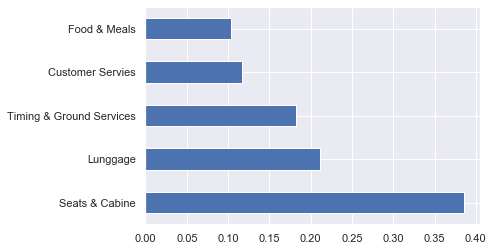

In [32]:
cls_bal.plot(kind='barh')

In [33]:
#There appears to be significant class imbalance. However, this isn't necessarily due to misclassification. 
#Most reviews are expected to talk about how a game lives up to the series it is from.
#will sample assuming equal probability first, seeing as the topics are not all confirmed to be correctly classified.

sample_tokens_df = tokens_df.sample(frac=0.1,random_state=1337) #take 10% of the data and sample it (according to http://www.raosoft.com/samplesize.html, 193 samples give ~7% margin of error)
sample_tokens_df.head()

,dominant_topic,original_text,topic_perc_contrib,tokens,num_tokens,unique_tokens,num_unique_tokens,keywords
194,Lunggage,"[phoenix, boston, americans, poor, maintenance...",0.8459,"[maintenance, 15_minutes, delay, flight, three...",18,"[customer_service, makes_sense, progress, dela...",15,"plane, american_airlines, airport, gate, delay..."
4044,Seats & Cabine,"[wonderful, service, flight, edinburghflorence...",0.8314,"[service, flight, british_airways, partner]",4,"[service, flight, partner, british_airways]",4,"seat, food, service, business_class, staff, ai..."
9518,Seats & Cabine,"[dublin, berlin, schönefeld, dublin, ryanair, ...",0.5222,"[change, baggage_policy, airline, meal, price,...",14,"[onboard_entertainment, walk, meal, change, ai...",13,"seat, food, service, business_class, staff, ai..."
7699,Seats & Cabine,"[colombo, copenhagen, dubai, return, emirates,...",0.7159,"[manchester_dubai, flight, frequent_flyer, fai...",21,"[durban, stuff, cabin_staff, manchester_dubai,...",18,"seat, food, service, business_class, staff, ai..."
3069,Lunggage,"[one, thing, airline, complimentary, flight, o...",0.5792,"[airline, flight, home, two_hrs, line, check, ...",17,"[two_hrs, line, day, terrible_customer_service...",16,"plane, american_airlines, airport, gate, delay..."


In [34]:
sample_tokens_df.to_csv('../supercase-airplane/data/sample_tokens_df.csv')

### Findings from the Samples

**General Findings**
- Long reviews tend to cover multiple topics. 
    - Classifying a whole review as being about one topic is one way of doing things, but it could mean wasted opportunities.
    - Could be worth analysing the dataset by sentences.</br></br>

**Sample with num_tokens <=5:**
- The cumulative misclassficiation rate of the low token count sample is between 20% (5 tokens) and 60% (0 tokens), which I can accept for text analysis...
    - ... for the Internet is dark and full of errors. 

A classification rate of around 80% classification success rate from an unsupervised model seems quite usable. 


**Sample with any number of tokens:**
- Overall classification accuracy of sample (10% of the whole dataset) is around 86%, which I find quite acceptable. 
    - The rate should be approximately the same for the whole dataset 
    - 5% margin of error according to http://www.raosoft.com/samplesize.html </br></br>
    
- 1 or fewer tokens dropped
    - Misclassification rate drops from ~14.8% to ~13.6%. 
    - We sacrifice 13.7% of the usable data. 
    - Possibly a worthy tradeoff. </br></br>
    
- 2 or fewer tokens dropped
    - Misclassification rate drops from ~13.6% to ~12.5%. 
    - However, we sacrifice 27.6% of the usable data. 
    - The loss of data is too severe to for this to be a worthy tradeoff. </br></br>

**NEXT STEPS**

- Remove reviews that have 0 or 1 tokens from the dataset
    - AFTER sentiment analysis 
    - model was trained on this dataset
    - Low token count reviews should be dropped only after all the model has been reloaded and topic assignment has been done (retroactively discovered this)
- Analyse the entire corpus by sentences instead of by document.
    - This way, there will be more data overall; long reviews can be broken down into parts that talk about different topics. 
- The resulting topics and sentiments can be grouped together for a more accurate overview of player sentiment overall, rather than sentiment for the dominant topic of each document

In [457]:
#Remove reviews with 1 or 0 tokens

#df_dominant_topic2=df_dominant_topic[df_dominant_topic['num_tokens']>1]

#Find out what proportion of reviews were dropped
#rows_removed = abs(len(df_dominant_topic)-len(df_dominant_topic2))/len(df_dominant_topic)
#print(rows_removed)

0.15542201584266593


In [458]:
#Get number of reviews remaining

#len(df_dominant_topic2)

3092

In [36]:
# df_dominant_topic2.to_csv('./dataframes/dominant_topics.csv')
df_dominant_topic.to_csv('../supercase-airplane/data/dominant_topics.csv')

In [462]:
len(df_dominant_topic)

3661